**PROBLEM 1: Aminer : basic dataset analysis**

In [1]:
!wget -O dataset.zip 'https://lfs.aminer.cn/lab-datasets/citation/acm.v9.zip'


--2025-01-17 03:19:07--  https://lfs.aminer.cn/lab-datasets/citation/acm.v9.zip
Resolving lfs.aminer.cn (lfs.aminer.cn)... 159.27.2.14
Connecting to lfs.aminer.cn (lfs.aminer.cn)|159.27.2.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Could not parse String-Transport-Security header
Length: 686542584 (655M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 654.74M  9.82MB/s    in 67s     

2025-01-17 03:20:15 (9.84 MB/s) - ‘dataset.zip’ saved [686542584/686542584]



In [2]:
!unzip dataset.zip -d /content/dataset


Archive:  dataset.zip
  inflating: /content/dataset/acm.txt  


**A. Compute the number of distinct authors, publication venues, publications, and citations/references.**

In [3]:
import pandas as pd

# Path to the dataset file
file_path = '/content/dataset/acm.txt'

# Lists to store parsed data
titles = []
authors = []
years = []
venues = []
indices = []
references = []

# Open and parse the file line by line
with open(file_path, 'r') as file:
    record = {'references': []}  # Add references field to each record
    for line in file:
        line = line.strip()
        if line.startswith("#*"):
            record['title'] = line[2:]  # Title
        elif line.startswith("#@"):
            record['authors'] = line[2:]  # Authors
        elif line.startswith("#t"):
            record['year'] = line[2:]  # Year
        elif line.startswith("#c"):
            record['venue'] = line[2:]  # Venue
        elif line.startswith("#index"):
            record['index'] = line[6:]  # Index
        elif line.startswith("#%"):
            # Append the reference (index of another publication) to the references list
            reference = line[2:].strip()
            if reference:
                record['references'].append(reference)
        elif line == "":
            # End of a record, append to lists
            if record:
                titles.append(record.get('title', ''))
                authors.append(record.get('authors', ''))
                years.append(record.get('year', ''))
                venues.append(record.get('venue', ''))
                indices.append(record.get('index', ''))
                references.append(record.get('references', []))
                record = {'references': []}  # Reset for the next record

# Create a DataFrame from the lists
df = pd.DataFrame({
    'title': titles,
    'authors': authors,
    'year': years,
    'venue': venues,
    'index': indices,
    'references': references
})

In [4]:
df.head()

,title,authors,year,venue,index,references
0,MOSFET table look-up models for circuit simula...,,1984,"Integration, the VLSI Journal",1,[]
1,The verification of the protection mechanisms ...,Virgil D. Gligor,1984,International Journal of Parallel Programming,2,[]
2,Another view of functional and multivalued dep...,"M. Gyssens, J. Paredaens",1984,International Journal of Parallel Programming,3,[]
3,Entity-relationship diagrams which are in BCNF,"Sushil Jajodia, Peter A. Ng, Frederick N. Spri...",1984,International Journal of Parallel Programming,4,[]
4,The computer comes of age,Rene Moreau,1984,The computer comes of age,5,[]


In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
# Number of distinct authors
authors_set = set()
df['authors'].str.split(',').dropna().apply(authors_set.update)
num_authors = len(authors_set)
print(f"Number of distinct authors: {num_authors}")

# Number of distinct venues
num_venues = df['venue'].nunique()
print(f"Number of distinct venues: {num_venues}")

# Number of distinct publications (based on unique titles)
num_publications = df['title'].nunique()
print(f"Number of distinct publications: {num_publications}")

# Note: Dataset example doesn't include references field.

Number of distinct authors: 2027009
Number of distinct venues: 273330
Number of distinct publications: 2183552


**B. Are these numbers likely to be accurate? As an example look up all the publications venue names associated with the conference “Principles and Practice of Knowledge Discovery in Databases” – what do you notice?**


In [7]:
# Filter the dataset for publications associated with the specified conference
conference_name = "Principles and Practice of Knowledge Discovery in Databases"

# Using case-insensitive matching
ppkdd_venues = df[df['venue'].str.contains(conference_name, case=False, na=False)]

unique_ppkdd_venues = ppkdd_venues['venue'].unique()

print("Unique venue names associated with 'Principles and Practice of Knowledge Discovery in Databases':\n")
for venue in unique_ppkdd_venues:
    print(venue)

# Count the number of occurrences for each venue name
venue_counts = ppkdd_venues['venue'].value_counts()

print("\nCounts of publications per venue name:\n")
print(venue_counts)


Unique venue names associated with 'Principles and Practice of Knowledge Discovery in Databases':

PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
Knowledge Discovery in Databases: PKDD 2006: 10th European Conference on Principles and Practice of Knowledge Discovery in Databases, Berlin, Germany, September ... (Lecture Notes in Computer Science)
Knowledge Discovery in Databases: PKDD 2005: 9th European Conference on Principles and Practice of Knowledge Discovery in Databases, Porto, Portugal, October ... / Lecture Notes in Artificial Intelligence)
PKDD 2007 Proceedings of the 11th European conference on Principles and Practice of Knowledge Discovery in Databases
PKDD'05 Proceedings of the 9th European conference on Principles and Practice of Knowledge Discovery in Databases

Counts of publications per venue name:

venue
PKDD'05 Proceedings of the 9th European conference on Principles and Practice of Knowledge Discovery 

It appears as though we have some inconsistent vanue naming conventions, some of our years are abbreviated like PKDD '04 and PKDD 2007.

We also have an inflated count of unique venues. This is because each variation is counted as a distinct venue, causing the inflation.


**C. For each author, construct the list of publications. Plot a histogram of the number of publications per author (use a logarithmic scale on the y axis)**

In [8]:
# Create a dictionary to store publications for each author
author_publications = defaultdict(list)

# Populate the dictionary
for _, row in df.iterrows():
    # Split authors by comma and strip whitespace, filter out empty strings
    authors = [author.strip() for author in row['authors'].split(',') if author.strip()]
    title = row['title']
    for author in authors:
        author_publications[author].append(title)

print("Sample of authors and their publication counts (after cleaning):")
for author, publications in list(author_publications.items())[:15]:
    print(f"Author: {author}, Number of Publications: {len(publications)}")


Sample of authors and their publication counts (after cleaning):
Author: Virgil D. Gligor, Number of Publications: 68
Author: M. Gyssens, Number of Publications: 7
Author: J. Paredaens, Number of Publications: 18
Author: Sushil Jajodia, Number of Publications: 418
Author: Peter A. Ng, Number of Publications: 36
Author: Frederick N. Springsteel, Number of Publications: 8
Author: Rene Moreau, Number of Publications: 1
Author: A. G. Akritas, Number of Publications: 4
Author: S. S. Lyengar, Number of Publications: 2
Author: A. A. Rampuria, Number of Publications: 1
Author: C. C. Chang, Number of Publications: 56
Author: M. W. Du, Number of Publications: 9
Author: R. C. T. Lee, Number of Publications: 59
Author: David Haussler, Number of Publications: 102
Author: Hans Röck, Number of Publications: 2


In [9]:
# List of publication counts for each author
publication_counts = [len(publications) for publications in author_publications.values()]

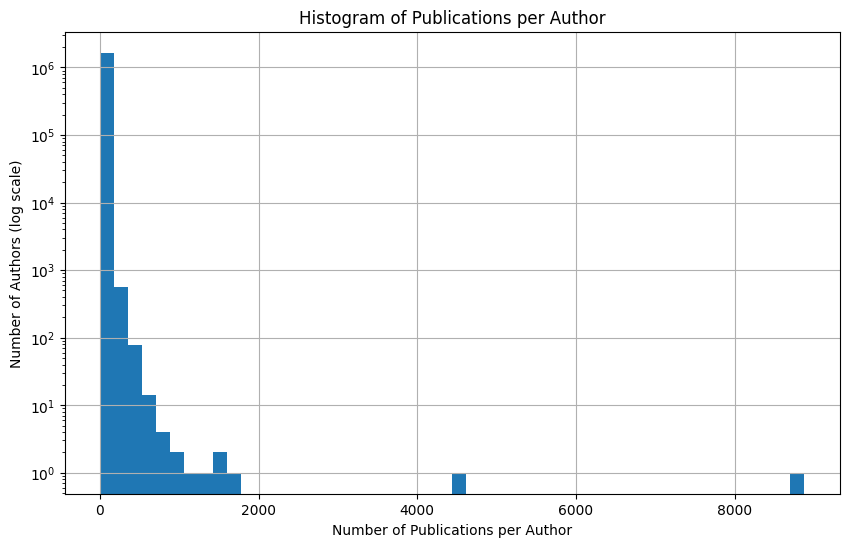

In [10]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(publication_counts, bins=50, log=True)
plt.xlabel('Number of Publications per Author')
plt.ylabel('Number of Authors (log scale)')
plt.title('Histogram of Publications per Author')
plt.grid(True)
plt.show()

**D. Calculate the mean and standard deviation of the number of publications per author. Also calculate the Q1 (1st quartile14), Q2 (2nd quartile, or median) and Q3 (3rd quartile) values. Compare the median to the mean and explain the difference between the two values based on the standard deviation and the 1st and 3rd quartiles.**

In [11]:
import numpy as np

# Calculate statistics
mean_publications = np.mean(publication_counts)
std_dev_publications = np.std(publication_counts)
q1 = np.percentile(publication_counts, 25)  # 1st quartile (25th percentile)
median_publications = np.median(publication_counts)  # 2nd quartile (50th percentile)
q3 = np.percentile(publication_counts, 75)  # 3rd quartile (75th percentile)

# Print results
print(f"Mean number of publications per author: {mean_publications:.2f}")
print(f"Standard deviation: {std_dev_publications:.2f}")
print(f"1st Quartile (Q1): {q1}")
print(f"Median (Q2): {median_publications}")
print(f"3rd Quartile (Q3): {q3}")


Mean number of publications per author: 3.46
Standard deviation: 12.77
1st Quartile (Q1): 1.0
Median (Q2): 1.0
3rd Quartile (Q3): 3.0


The mean represents the average number of publications per author. While the median represents the middle value when the number of publications is sorted.

Interpreting this information lets us know that:
The mean 3.46 is slightly higher than our median of 1.0, this indicates a right-skewed distribution. This means that most authors have very few publications, a small number of authors have significantly more publications, raising our mean.

With our standard deviation of 12.77 being much larger than the mean, this shows us that there is a high variability in the number of publications per author. This reinforces the claim above that a small amount of authors disproportionally dominates the high publication counts.

Quartiles:
Q1 - 25% of authors only have 1 publication or lower.
Median Q2 - 50% of authors have 1 publication of lower.
Q3 - 75% of authors have 3 publications or fewer.
Interquartile range = Q3 - Q1 = 3.0 - 1.0 - 2.0. Shows us that the majority of authors have publication counts in a lower range (1-3 publications).



**E. Now plot a histogram of the number of publications per venue, as well as calculate the mean, standard deviation, median, Q1, and Q3 values. What is the venue with the largest number of publications in the dataset?**

In [12]:
# Calculate the number of publications per venue
venue_publication_counts = df['venue'].value_counts()

# Display the venue with the largest number of publications
most_popular_venue = venue_publication_counts.idxmax()
most_publications = venue_publication_counts.max()

print(f"Venue with the largest number of publications: {most_popular_venue}")
print(f"Number of publications in {most_popular_venue}: {most_publications}")


Venue with the largest number of publications: IEEE Transactions on Information Theory
Number of publications in IEEE Transactions on Information Theory: 12754


In [13]:
import numpy as np

# Convert counts to a list
venue_counts = venue_publication_counts.values

# Calculate statistics
mean_venue_publications = np.mean(venue_counts)
std_dev_venue_publications = np.std(venue_counts)
median_venue_publications = np.median(venue_counts)
q1_venue_publications = np.percentile(venue_counts, 25)
q3_venue_publications = np.percentile(venue_counts, 75)

# Print results
print(f"Mean number of publications per venue: {mean_venue_publications:.2f}")
print(f"Standard deviation: {std_dev_venue_publications:.2f}")
print(f"1st Quartile (Q1): {q1_venue_publications}")
print(f"Median (Q2): {median_venue_publications}")
print(f"3rd Quartile (Q3): {q3_venue_publications}")


Mean number of publications per venue: 8.73
Standard deviation: 106.80
1st Quartile (Q1): 1.0
Median (Q2): 1.0
3rd Quartile (Q3): 1.0


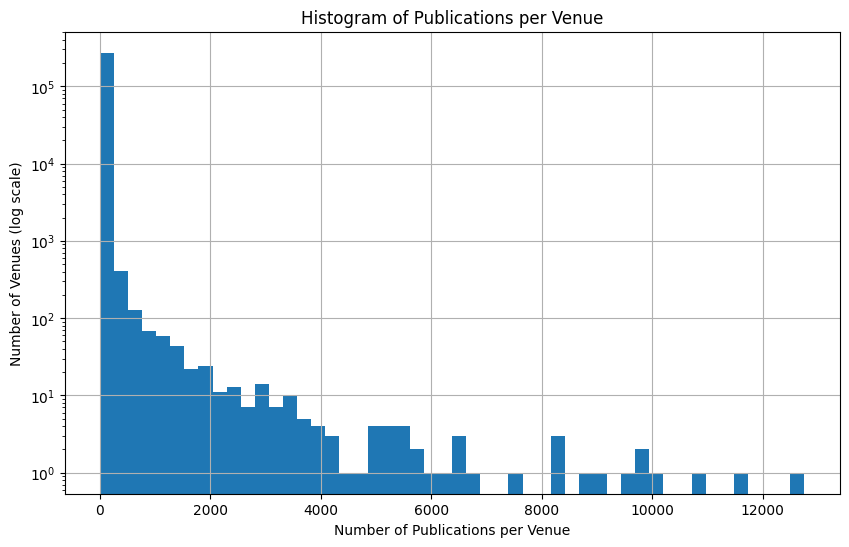

In [14]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(venue_counts, bins=50, log=True)
plt.xlabel('Number of Publications per Venue')
plt.ylabel('Number of Venues (log scale)')
plt.title('Histogram of Publications per Venue')
plt.grid(True)
plt.show()


**F. Plot a histogram of the number of references (number of publications a publication refers to) and citations (number of publications referring to a publication) per publication. What is the publication with the largest number of references? What is the publication with the largest number of citations? Do these make sense?**

In [15]:
# Calculate the number of references per publication
df['num_references'] = df['references'].apply(len)

# Find the publication with the largest number of references
publication_with_most_references = df.loc[df['num_references'].idxmax()]
print("Publication with the largest number of references:")
print(f"Title: {publication_with_most_references['title']}")
print(f"Number of References: {publication_with_most_references['num_references']}")

Publication with the largest number of references:
Title: Proceedings of the Twenty-Fourth ACM Symposium on Operating Systems Principles
Number of References: 809


In [16]:
from itertools import chain
from collections import Counter

# Ensure references are lists
df['references'] = df['references'].apply(lambda x: x if isinstance(x, list) else [])

# Efficiently flatten all references
all_references = chain.from_iterable(df['references'])

# Count citations for each publication index
citation_counts = Counter(all_references)

# Ensure index column is string for consistency
df['index'] = df['index'].astype(str)

# Add citation counts to the DataFrame
df['num_citations'] = df['index'].apply(lambda x: citation_counts.get(x, 0))

# Find the publication with the largest number of citations
publication_with_most_citations = df.loc[df['num_citations'].idxmax()]
print("\nPublication with the largest number of citations:")
print(f"Title: {publication_with_most_citations['title']}")
print(f"Number of Citations: {publication_with_most_citations['num_citations']}")



Publication with the largest number of citations:
Title: INFORMS Journal on Computing
Number of Citations: 938039


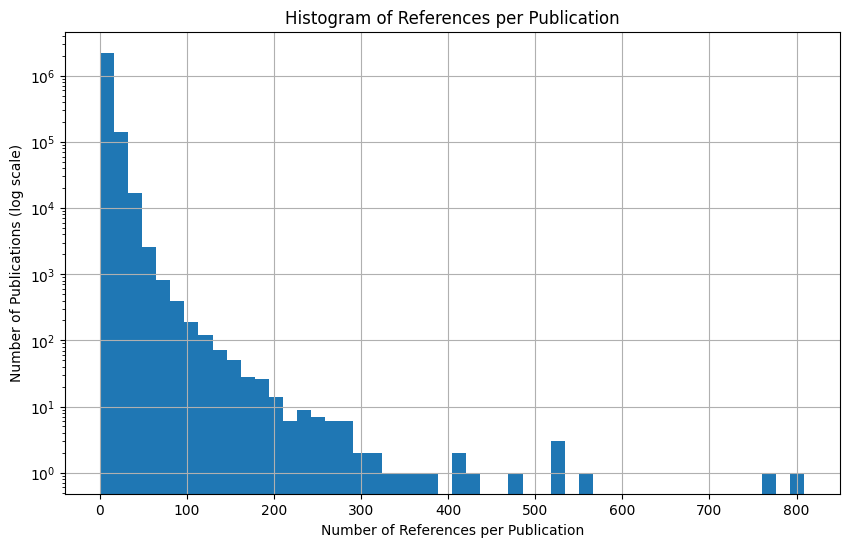

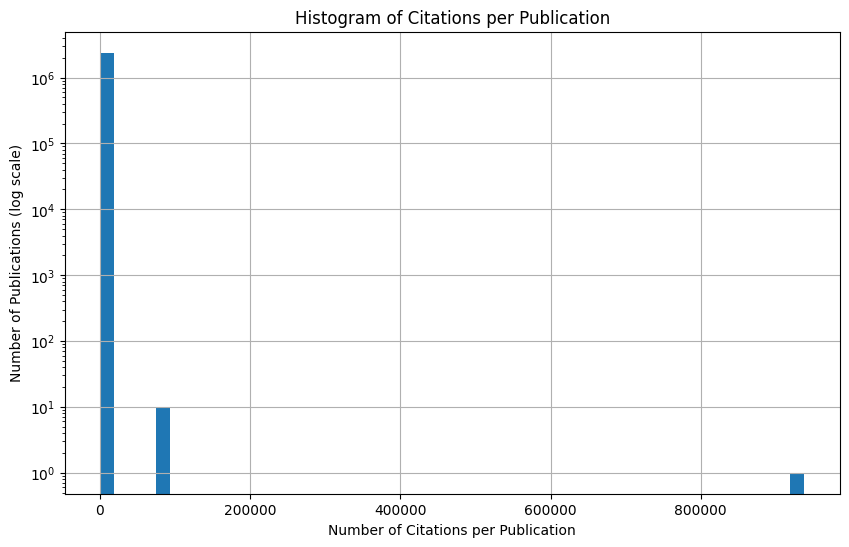

In [19]:
import matplotlib.pyplot as plt

# Plot histogram for number of references
plt.figure(figsize=(10, 6))
plt.hist(df['num_references'], bins=50, log=True)
plt.xlabel('Number of References per Publication')
plt.ylabel('Number of Publications (log scale)')
plt.title('Histogram of References per Publication')
plt.grid(True)
plt.show()

# Plot histogram for number of citations
plt.figure(figsize=(10, 6))
plt.hist(df['num_citations'], bins=50, log=True)
plt.xlabel('Number of Citations per Publication')
plt.ylabel('Number of Publications (log scale)')
plt.title('Histogram of Citations per Publication')
plt.grid(True)
plt.show()